In [17]:
# Import all the libraries I need
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore Deprecation Warning
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer
from sklearn.pipeline import make_pipeline

#from sklearn.metrics import multilabel_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.multioutput import MultiOutputClassifier

import pyarrow.parquet as pq

import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning)
#warnings.filterwarnings("ignore", category=UserWarning)
#warnings.filterwarnings("ignore", category=FutureWarning)

base_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/'
embed_path = '/Users/ryan/neue_fische/human-protein-atlas-image-classification/data/embeddings_train/'


In [2]:
#get all of the labels
labels_training = pd.read_csv(base_path+'train.csv')

In [2]:
labels_training

NameError: name 'labels_training' is not defined

In [4]:
class Location_in_Target(object):
    ''' Class to get a list of name of pictures which are labeled with a specific 
        location and the same number of names of pictures which labels do not 
        contain the specific location.
        ...
        Attributes:
        ----------
        location: int 
            number which define a location in a human cell
        pictures: panda.DataFrame
            list of the names of the pictures labeled with the location and 
            same number of pictures without the label
        
        Methods:
        ----------
        save_pictures(pictures, column_name):
            Saves the list of picture names in an Attribute
        get_pictures()
            Returns the list of picture names
        determine_pictures(labels)  
            Find pictures with and without the specific label and call save method
            when list is build
    '''

    def __init__(self, location): 
        '''Parameters
           ----------
           location: int 
                number which define a location in a human cell
        '''

        self.location = location
        self.pictures = pd.DataFrame()

    def save_pictures(self, pictures, column_name):
        ''' Saves the list of pictures in the attribute pictures

            Parameters
            ----------
            pictures: panda.DataFrame
                list of the names of the pictures labeled with the location and 
                same number of pictures without the label
            column_name: str
                Description of the data saved in the DataFrame used as column names 
        '''

        self.pictures[column_name] = pictures

    def get_pictures(self):
        '''Gives back the list of picture names which are labeled or not labeled
            with the given location
        '''

        return self.pictures

    def determine_pictures(self, labels):
        ''' First the names of the pictures labeled with the given location are 
            saved in a list and the method to save it in a DataFrame column is 
            called. 
            The same number of names from pictures not labeled with the location 
            are chosen randomly. The saving function is called with it again. 

            Parameters
            ----------
            labels: DataFrame with all picture names and Targets       
        '''

        pictures = [label.Id  for index, label in labels.iterrows() 
                              if str(self.location) in label.Target]
        self.save_pictures(pictures, f'pictures_with_location_{self.location}')
        #The number of pictures labeled with the given location is needed to get the 
        #same number of pictures not labeled with the location
        number_needed_pictures= len(pictures)
        pictures = [label.Id  for index, label in labels.iterrows() 
                              if str(self.location) not in label.Target]
        self.save_pictures(np.random.choice(pictures, number_needed_pictures),
                                f'pictures_without_location_{self.location}')

#### Load the full set of embeddings

In [5]:
# load embeddings (saved as parquet files), convert to pandas and get strings as strings
emb = pq.read_table(embed_path).to_pandas()
for col in ['target_id', 'image_path', 'image_name']:
    emb[col] = emb[col].str.decode('utf-8')#.fillna(df[col]) 
emb

,target_id,image_path,embedding,image_name
0,7,../data/train/4b0d7acc-bbb5-11e8-b2ba-ac1f6b64...,"[-0.14782768, -0.19346946, 0.029495712, -0.114...",4b0d7acc-bbb5-11e8-b2ba-ac1f6b6435d0
1,5 0,../data/train/4b0e4648-bbc2-11e8-b2bb-ac1f6b64...,"[-0.11768038, 0.108380914, -0.07158355, -0.051...",4b0e4648-bbc2-11e8-b2bb-ac1f6b6435d0
2,23,../data/train/4b0fe352-bbbf-11e8-b2ba-ac1f6b64...,"[-0.14264518, -0.14894637, 0.015262008, -0.138...",4b0fe352-bbbf-11e8-b2ba-ac1f6b6435d0
3,2,../data/train/4b1164e4-bbaf-11e8-b2ba-ac1f6b64...,"[-0.14977421, -0.12706101, -0.17702478, -0.087...",4b1164e4-bbaf-11e8-b2ba-ac1f6b6435d0
4,25,../data/train/4b120c9e-bbb1-11e8-b2ba-ac1f6b64...,"[-0.15020615, -0.008659467, -0.14262204, -0.04...",4b120c9e-bbb1-11e8-b2ba-ac1f6b6435d0
...,...,...,...,...
31067,7,../data/train/9d04d730-bbb5-11e8-b2ba-ac1f6b64...,"[-0.095827445, -0.14014255, -0.1306586, -0.081...",9d04d730-bbb5-11e8-b2ba-ac1f6b6435d0
31068,4,../data/train/9d09c7e0-bb9c-11e8-b2b9-ac1f6b64...,"[-0.109680824, -0.07402489, -0.08704822, -0.08...",9d09c7e0-bb9c-11e8-b2b9-ac1f6b6435d0
31069,0,../data/train/9d0a7012-bbc6-11e8-b2bc-ac1f6b64...,"[-0.14760047, -0.105946906, 0.17695697, -0.130...",9d0a7012-bbc6-11e8-b2bc-ac1f6b6435d0
31070,25 0,../data/train/9d10ecec-bba0-11e8-b2b9-ac1f6b64...,"[-0.12235144, -0.12698074, -0.052961998, -0.10...",9d10ecec-bba0-11e8-b2b9-ac1f6b6435d0


#### Test the class with Mitochondria labeled with a 23
- create a balanced subset of images that have mitochondria or not

In [6]:
mitochondria_pictures = Location_in_Target(location = 23)
mitochondria_pictures.determine_pictures(labels_training)
#Dataframe with filenames of pictures which have mitochondria
df_mit = mitochondria_pictures.get_pictures().pictures_with_location_23
#Dataframe with filenames of pictures which have no mitochondria
df_no_mit = mitochondria_pictures.get_pictures().pictures_without_location_23

In [7]:
# use join to pull out the embeddings of the mitochondria subset
# first get the mitochondria and set target = 1
emb_mit = emb.merge(df_mit.rename("image_name").to_frame(), how="right", on="image_name")
emb_mit["target_id"] = 1
# now the others, target = 0
emb_no_mit = emb.merge(df_no_mit.rename("image_name").to_frame(), how="right", on="image_name")
emb_no_mit["target_id"] = 0
# now combine them into one table and shuffle
df_emb_mit = pd.concat([emb_mit, emb_no_mit]).reset_index()
df_emb_mit = shuffle(df_emb_mit, random_state=0)

In [8]:
# put the features (embeddings) in one dataframe
df_feats = pd.DataFrame(list(map(np.ravel, df_emb_mit.embedding)))

In [9]:
# get the targets, one hot encode and put into a dataframe

# courtesy of https://www.kaggle.com/code/allunia/protein-atlas-exploration-and-baseline
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

# target dataframe
targets = df_emb_mit['target_id']
targets

5852    0
5766    0
4501    0
1595    1
918     1
       ..
4931    0
3264    0
1653    1
2607    1
2732    1
Name: target_id, Length: 5930, dtype: int64

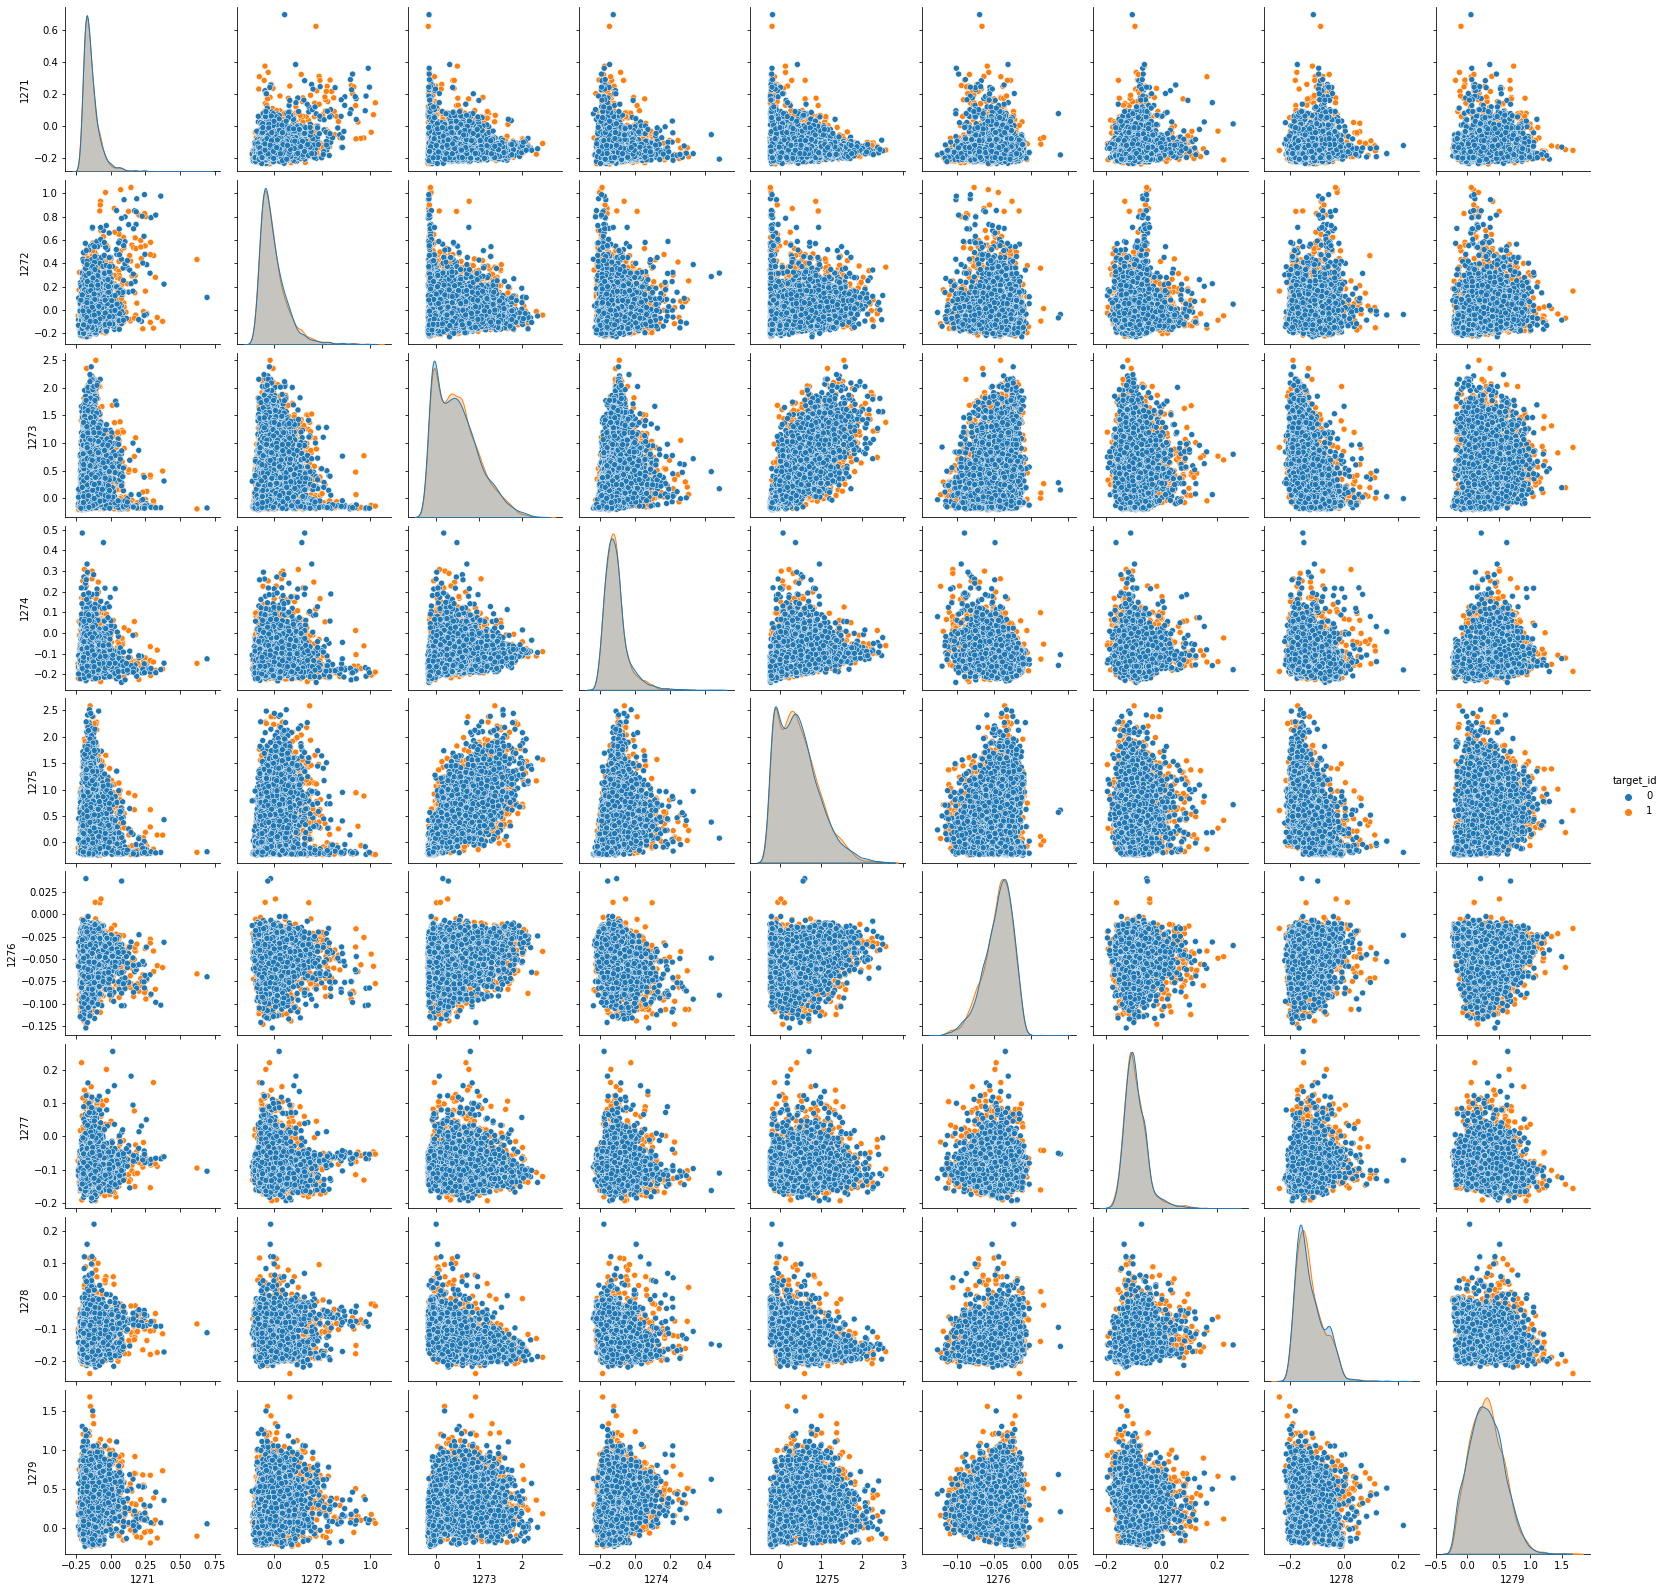

In [11]:
sns.pairplot(pd.concat([df_feats,targets],axis=1).iloc[:,-10:], hue="target_id");

### Notes:
- data may still need to be scaled
- also not uniformly distributed --- log?

In [13]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(df_feats, targets, random_state=1)

### Setup pipeline to preprocess data and train the model
- setting up "switcher class" so that we can try different model/classifiers; from https://stackoverflow.com/questions/51695322/compare-multiple-algorithms-with-sklearn-pipeline
 

In [22]:
from sklearn.base import BaseEstimator

class ClfSwitcher(BaseEstimator):
    def __init__(
        self, 
        estimator = KNeighborsClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

#### Compare different models (but not hyperparameters for now)

In [63]:
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Define fbeta score as the metric to compare the models
f_beta = 1
fbeta_scorer = make_scorer(fbeta_score, beta=f_beta)

pipeline = Pipeline([
    ('quant', QuantileTransformer(random_state=0)), 
    ('stscale',StandardScaler()),
    ('clf', ClfSwitcher()),
])

# set up the different models like hyperparameters
# list_of_clf = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(random_state=42)]

parameters = [
#    {
#        'clf__estimator': [SGDClassifier()], 
#        'clf__estimator__penalty': ('l2'), # , 'elasticnet', 'l1'
#    },    
    #{
    #    'clf__estimator': [DecisionTreeClassifier(random_state=42)], 
    #},    
    {
        'clf__estimator': [KNeighborsClassifier()], #n_neighbors=3, p=1
        'clf__estimator__p': [1],
        'clf__estimator__n_neighbors': [3],
    },
#    {
#        'clf__estimator': [LogisticRegression()], 
#        'clf__estimator__penalty': ('l2'),
#    },
    {
        'clf__estimator': [SVC()], 
        'clf__estimator__kernel': ['rbf', 'sigmoid'], #'linear', ,'poly'
        'clf__estimator__C': [10, 100, 1000], # 0.1, 1, 
    },
    # { just gives nan, can't handle negative data
    #     'clf__estimator': [MultinomialNB()], 
    # },
]

gscv = GridSearchCV(pipeline, parameters, cv=5, n_jobs=12, return_train_score=False, verbose=3,
                    scoring=fbeta_scorer)
gscv.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3, clf__estimator__p=1;, score=0.630 total time= 1.4min
[CV 3/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3, clf__estimator__p=1;, score=0.638 total time= 1.5min
[CV 2/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3, clf__estimator__p=1;, score=0.612 total time= 1.5min
[CV 5/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3, clf__estimator__p=1;, score=0.586 total time= 1.5min
[CV 4/5] END clf__estimator=KNeighborsClassifier(), clf__estimator__n_neighbors=3, clf__estimator__p=1;, score=0.611 total time= 1.5min
[CV 2/5] END clf__estimator=SVC(), clf__estimator__C=10, clf__estimator__kernel=sigmoid;, score=0.592 total time= 1.6min
[CV 1/5] END clf__estimator=SVC(), clf__estimator__C=10, clf__estimator__kernel=sigmoid;, score=0.555 total time= 1.6min
[CV 1/5] END clf__

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('quant',
                                        QuantileTransformer(random_state=0)),
                                       ('stscale', StandardScaler()),
                                       ('clf', ClfSwitcher())]),
             n_jobs=12,
             param_grid=[{'clf__estimator': [KNeighborsClassifier()],
                          'clf__estimator__n_neighbors': [3],
                          'clf__estimator__p': [1]},
                         {'clf__estimator': [SVC(C=10)],
                          'clf__estimator__C': [10, 100, 1000],
                          'clf__estimator__kernel': ['rbf', 'sigmoid']}],
             scoring=make_scorer(fbeta_score, beta=1), verbose=3)

#### Notes:
- check the output of the QuantileTransformer, does it make distributions uniform?
- need to deal with overfitting
- 

In [64]:
# Returning best score (recall) after GridSearch and parameter combination
print("                Best score:", gscv.best_score_.round(4))
print("Best parameter combination:", gscv.best_params_)
best_of_best = gscv.best_estimator_

                Best score: 0.6832
Best parameter combination: {'clf__estimator': SVC(C=10), 'clf__estimator__C': 10, 'clf__estimator__kernel': 'rbf'}


In [65]:
gscv.cv_results_['param_clf__estimator'], gscv.cv_results_['mean_test_score']

(masked_array(data=[KNeighborsClassifier(), SVC(C=10), SVC(C=10),
                    SVC(C=10), SVC(C=10), SVC(C=10), SVC(C=10)],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 array([0.61529981, 0.68320904, 0.56593032, 0.68053035, 0.56532205,
        0.67398279, 0.56484531]))

### Run the best model on the training data

Best model on train data
fbeta score: 0.9936
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2193
           1       0.99      1.00      0.99      2254

    accuracy                           0.99      4447
   macro avg       0.99      0.99      0.99      4447
weighted avg       0.99      0.99      0.99      4447

------------------------------------------------------------


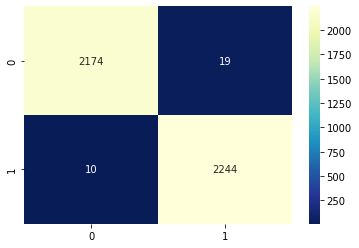

In [66]:
# Plot confusion matrix and classification report for best model
y_in = y_train
x_in = X_train
y_pred = best_of_best.predict(x_in)

print("Best model on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_in, y_pred, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_in, y_pred))
print("---"*20)

cm = confusion_matrix(y_in, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Predict with test data

Best model on train data
fbeta score: 0.6676
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       772
           1       0.65      0.69      0.67       711

    accuracy                           0.67      1483
   macro avg       0.67      0.67      0.67      1483
weighted avg       0.67      0.67      0.67      1483

------------------------------------------------------------


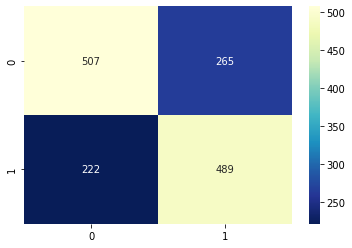

In [68]:
# Plot confusion matrix and classification report for best model
y_in = y_test
x_in = X_test
y_pred = best_of_best.predict(x_in)

print("Best model on train data")
print("==="*20)
print("fbeta score:", fbeta_score(y_in, y_pred, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_in, y_pred))
print("---"*20)

cm = confusion_matrix(y_in, y_pred)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");

### Initial pipeline setup for a KNN model

In [19]:
knn_pipe = make_pipeline(QuantileTransformer(random_state=0), StandardScaler(), 
                     KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
knn_pipe.fit(X_train, y_train)  # apply scaling on training data


Pipeline(steps=[('quantiletransformer', QuantileTransformer(random_state=0)),
                ('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(metric='euclidean'))])

### Predict data

KNN on test data
fbeta score: 0.6216
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       772
           1       0.55      0.64      0.59       711

    accuracy                           0.58      1483
   macro avg       0.58      0.58      0.58      1483
weighted avg       0.58      0.58      0.58      1483

------------------------------------------------------------


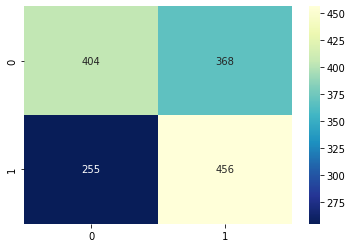

In [20]:
# Predict on test set
y_test_pred_knn = knn_pipe.predict(X_test)

print("KNN on test data")
print("==="*20)
print("fbeta score:", fbeta_score(y_test, y_test_pred_knn, beta=f_beta).round(4))
print("---"*20)
print(classification_report(y_test, y_test_pred_knn))
print("---"*20)


cm = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(cm, cmap="YlGnBu_r", annot=True, fmt=".0f");